# Classifying Knee Laterality with a CNN
This is the recognition project component of COMP3710.

s4361465 Kelsey McGahan 

Given a database of MRI images of left and right knees I was able 
to build a Convolutional Neural Network (CNN) that performed binary
classification. The data was supplied and preprocessed by the course
and was sourced from the 
[Osteoarthritis Initiative](https://nda.nih.gov/oai/). 
For further details see README.md.

In [1]:
import tensorflow as tf
from tensorflow import image
from tensorflow.keras import layers, models, preprocessing
import matplotlib.pyplot as plt
import numpy as np
import cv2
import wget
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Built in modules with Python 3.7
import random
import zipfile
import pathlib
from os import path

# Download data from URL and Unzip
Alternatively you can unzip this to the same directory as this Notebook. The unzipped data file must have name "AKOA_Analysis" (or you could adjust the ``data_dir`` value below). 

In [2]:
data_dir = "AKOA_Analysis"
# chekc if data folder already exists
if not path.exists(data_dir):
    # Want to try and download the dataset from URL and unzip
    url = "https://cloudstor.aarnet.edu.au/sender/download.php?token=d82346d9-f3ca-48bf-825f-327a622bfaca&files_ids=9881639"
    wget.download(url)
    with zipfile.ZipFile("AKOA_Analysis.zip", "r") as zip_ref:
        zip_ref.extractall()
    # file now in directory called AKOA_Analysis, that contains all the images

# Get List of Filenames in Dataset and Count Images

In [3]:
data_dir = pathlib.Path(data_dir)

total_images = list(data_dir.glob('*.png'))
print('total images', len(total_images))

left_images = list(data_dir.glob('*left*.png'))
left_underscored = list(data_dir.glob('*L_E_F_T*.png'))
left_images = left_images + left_underscored
print('left images', len(left_images))

right_images = list(data_dir.glob('*right*.png'))
right_underscored = list(data_dir.glob('*R_I_G_H_T*.png'))
right_images = right_images + right_underscored
print('right count', len(right_images))

print('sum ', len(right_images)+len(left_images))

total images 18680
left images 7760
right count 10920
sum  18680


# Generate images of left and right knees

Text(0.5, 1.0, 'Left Knee')

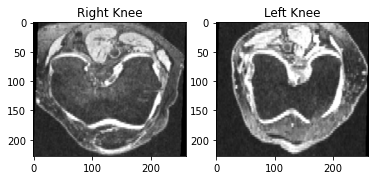

In [4]:
image1 = plt.imread(right_images[1])
image2 = plt.imread(left_images[1])

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image1)
ax1.set_title('Right Knee')
ax2.imshow(image2)
ax2.set_title('Left Knee')

# Extract Labels from Filenames and Allocate to Separate Array

In [5]:
# initialising the labels array 
total_images_labels = np.array([None]*len(total_images))
left = ["left", "l_e_f_t"]
right = ["right", "r_i_g_h_t"]

# labelling the images based on contents of path
for i in range(len(total_images)):
    path = total_images[i]
    # make path names all lowercase
    path = str(path).lower()
    
    # check laterality and give label of 0 (left) or 1(right) for that index of labels array
    if any(x in path for x in left):
        total_images_labels[i] = 0  # left
    elif any(x in path for x in right):
        total_images_labels[i] = 1  # right
    else:
        print("Unclassified Images: ", total_images[i])  # print to screen any path names that aren't covered
total_images_labels = total_images_labels.reshape((len(total_images),1))
print(total_images_labels.shape)

(18680, 1)


# Read, Resize and Reshape Images
This section takes a while to run (2-5 minutes), it could be improved by using a generator
to feed data into the model instead of 1 very large array. 

In [6]:
# Initialise new array to load images into
loaded_images = np.array([None]*len(total_images))
# loop through images, resizing and reshaping them and reassigning 
# to new array
for i in range(len(total_images)):
    loaded_images[i] = cv2.resize(plt.imread(total_images[i]), 
                                  (64, 64)).reshape((1, 64, 64, 3)) 

# concatenate all the images into the same array object
loaded_images = np.concatenate(loaded_images, axis=0)

# check the resulting shape 
print("Shape of Images array: ", loaded_images.shape)

Shape of Images array:  (18680, 64, 64, 3)


# Split the Dataset into Training and Testing

In [56]:
train_images, test_images, train_labels, test_labels=train_test_split(
    loaded_images,total_images_labels, test_size=0.7,random_state=101)

In [57]:
 # Need to convert arrays to tensors in future code
 def conv_tensor(arg):
    """ Function to convert arrays to tensors.
    Parameters:
         arg: the numpy array/list/scalar to be converted to a tensor.
    Return:
         arg: the now converted Tensorflow tensor."""
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

# convert our arrays to tensors
train_images = conv_tensor(train_images)
test_images = conv_tensor(test_images)
train_labels = conv_tensor(train_labels)
test_labels = conv_tensor(test_labels)

Checking the split of left/right in the train and test sets.

In [58]:
print('Num of rights:', sum(train_labels))
print('Total Training', len(train_labels))

print('Num of rights:', sum(test_labels))
print('Total Test', len(test_labels))

Num of rights: tf.Tensor([3314.], shape=(1,), dtype=float32)
Total Training 5604
Num of rights: tf.Tensor([7606.], shape=(1,), dtype=float32)
Total Test 13076


# Generating and Training the Model

In [59]:
# Calling the CNN model function
from Classify_Knee_Laterality_Model import classification
model = classification(images_shape=(64, 64, 3))

# Display the model
model.summary()

# compile and fit the model to the dataset
model.compile(loss='binary_crossentropy', optimizer='Adam', 
              metrics =['accuracy'])
history = model.fit(train_images, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_images, test_labels))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
flatten_8 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               7872640   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 7,873,217
Trainable params: 7,873,217
Non-trainable params: 0
_________________________________________________________________
Train on 5604 samples, validate on 13076 samples
Epoch 1/5
5604/5604 [==============================] - 10s 2ms/sample - loss: 0.1994 - accuracy: 0.9540 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 2/5
5604/5604 [==========================

# Plot the Accuracy and Loss 

Text(0.5, 1.0, 'Loss')

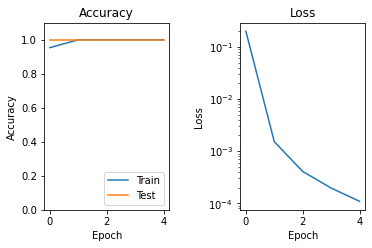

In [61]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout(pad=4.0)

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Test')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.0, 1.1])
ax1.legend(loc='lower right')
ax1.set_title('Accuracy')

ax2.plot(history.history['loss'], label='loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Loss')